In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import joblib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

# Load directory for features/vectorizer (input)
input_dir = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering'

# Save directory for model artifacts (output)
output_dir = '/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load TF-IDF features and vectorizer from input_dir
df = pd.read_pickle(os.path.join(input_dir, 'features_tfidf.pkl'))
vectorizer = joblib.load(os.path.join(input_dir, 'vectorizer_tfidf.pkl'))

# Prepare feature matrix
X = df.drop(['label', 'label_num'], axis=1).values

# Apply PCA
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(X)

# Train KMeans with k=5
model = KMeans(n_clusters=5, random_state=42)
model.fit(X_reduced)

# Save model, PCA, vectorizer to output_dir
joblib.dump(model, os.path.join(output_dir, 'kmeans_tfidf_k5.pkl'))
joblib.dump(pca, os.path.join(output_dir, 'pca_tfidf_100.pkl'))
joblib.dump(vectorizer, os.path.join(output_dir, 'vectorizer_tfidf.pkl'))  # overwrite optional

# Get cluster labels
cluster_labels = model.labels_

# Add to dataframe
df['cluster_label'] = cluster_labels

# Save updated dataframe
output_path = os.path.join(output_dir, 'Kmeans_tfidf_with_clusters_label.xlsx')
df.to_excel(output_path, index=False)

print(f"Saved dataframe with cluster labels to: {output_path}")


Saved dataframe with cluster labels to: /content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/Kmeans_tfidf_with_clusters_label.xlsx


Error Analysis

Cohen's Kappa (KMeans): 0.840


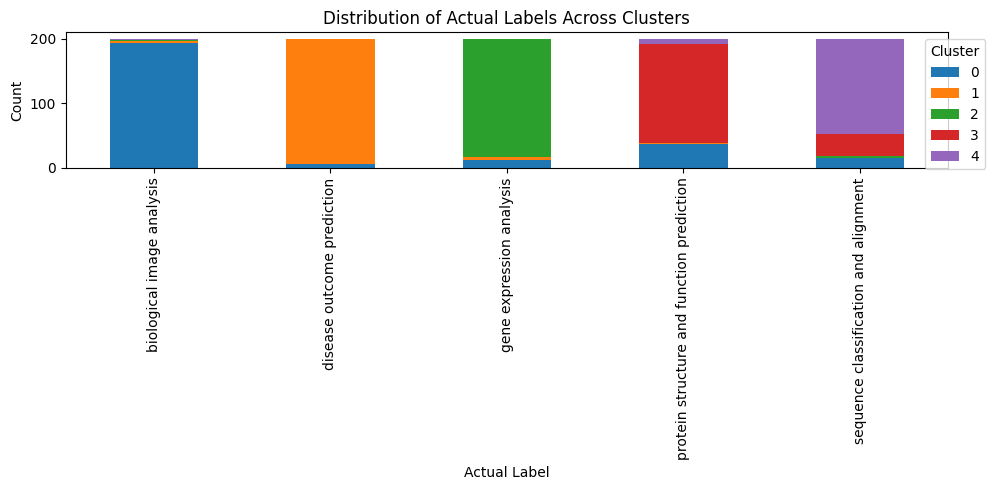

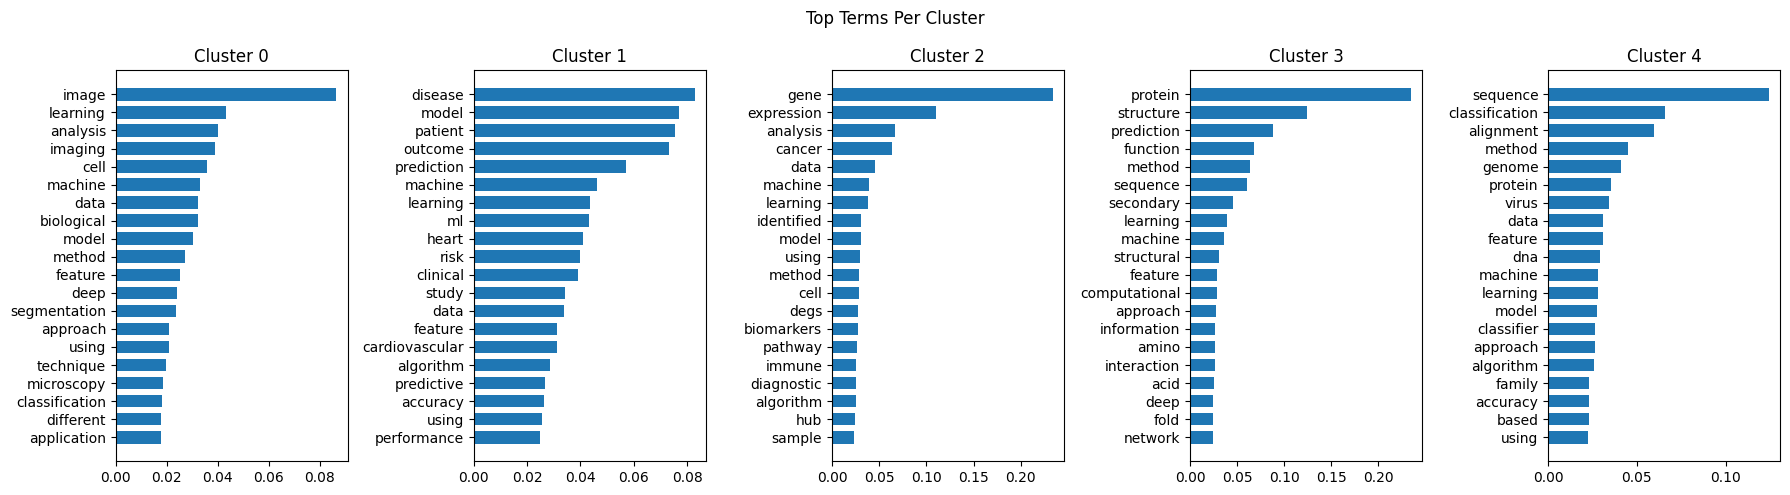

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Excel File ===
doc_raw = pd.read_excel('/content/drive/My Drive/Colab/AS4/STEP1-data_prepare/final_labeled_dataset.xlsx')

# === Use 'Text' and 'Label' columns ===
texts = doc_raw['Text'].astype(str).tolist()
label_names = doc_raw['Label'].astype(str)
label_to_num = {label: idx for idx, label in enumerate(sorted(label_names.unique()))}
numeric_labels = label_names.map(label_to_num).tolist()

# === TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(texts)
terms = vectorizer.get_feature_names_out()

# === Dimensionality Reduction (PCA) ===
pca = PCA(n_components=100, random_state=42)
tfidfp = pca.fit_transform(tfidf.toarray())

# === Clustering ===
n_clusters = len(set(numeric_labels))  # Set based on number of unique labels
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(tfidfp)

# === Align cluster labels to match actual labels ===
def align_cluster_labels(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_map = {pred: true for true, pred in zip(row_ind, col_ind)}
    aligned_labels = np.array([label_map[p] for p in pred_labels])
    return aligned_labels

k_aligned_labels = align_cluster_labels(numeric_labels, kmeans_labels)

# === Kappa Score ===
kkappa = cohen_kappa_score(numeric_labels, k_aligned_labels)
print(f"Cohen's Kappa (KMeans): {kkappa:.3f}")

# === Visualize Cluster Distribution ===
df = pd.DataFrame({
    'Actual': [list(label_to_num.keys())[i] for i in numeric_labels],
    'Cluster': k_aligned_labels
})
counts = df.groupby(['Actual', 'Cluster']).size().unstack()
counts.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Distribution of Actual Labels Across Clusters')
plt.ylabel('Count')
plt.xlabel('Actual Label')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# === Get Top Terms Per Cluster ===
def get_top_terms(labels, tfidf_matrix, feature_names, n_clusters):
    term_weights = np.zeros((n_clusters, tfidf_matrix.shape[1]))
    for cluster_id in range(n_clusters):
        cluster_mask = (labels == cluster_id)
        if np.sum(cluster_mask) > 0:
            term_weights[cluster_id] = tfidf_matrix[cluster_mask].mean(axis=0).A1
    return term_weights

def plot_top_words(weights, feature_names, n_top_words, title="Top Terms"):
    n_clusters = weights.shape[0]
    fig, axes = plt.subplots(1, n_clusters, figsize=(18, 5))
    if n_clusters == 1:
        axes = [axes]

    for cluster_idx, cluster_weights in enumerate(weights):
        top_features_ind = cluster_weights.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        term_weights = cluster_weights[top_features_ind]

        ax = axes[cluster_idx]
        ax.barh(top_features, term_weights, height=0.7)
        ax.set_title(f"Cluster {cluster_idx}")
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# === Plot Top Terms ===
kmw = get_top_terms(np.array(k_aligned_labels), tfidf, terms, n_clusters)
plot_top_words(kmw, terms, 20, "Top Terms Per Cluster")


Cohen's Kappa KM: 0.890


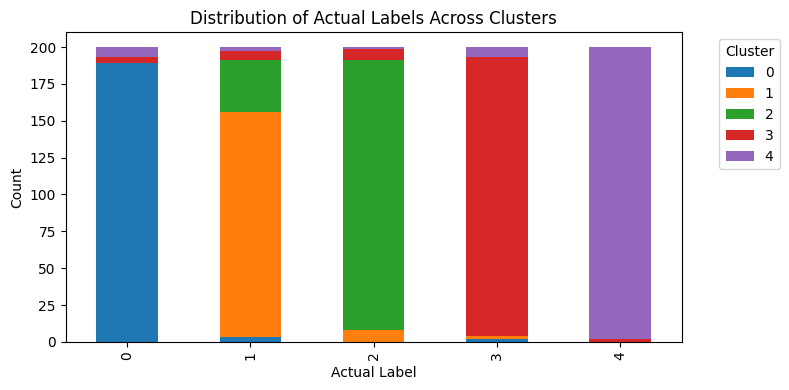

Comparison Metrics:
KMeans vs LDA - ARI: -0.000
KMeans vs LDA - NMI: 0.004


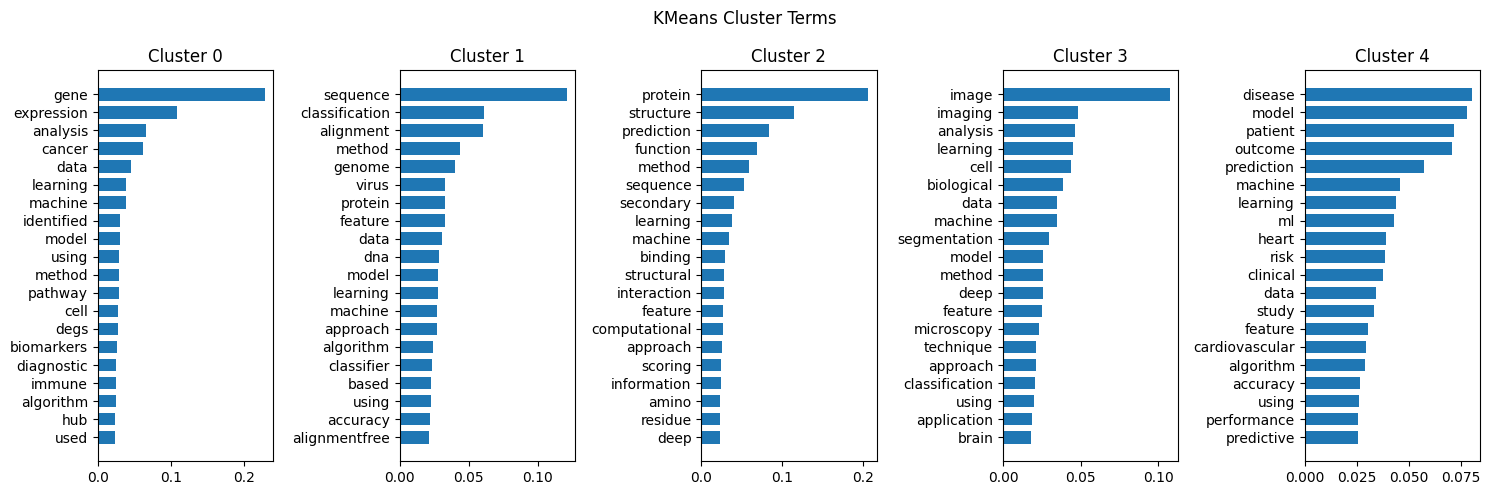

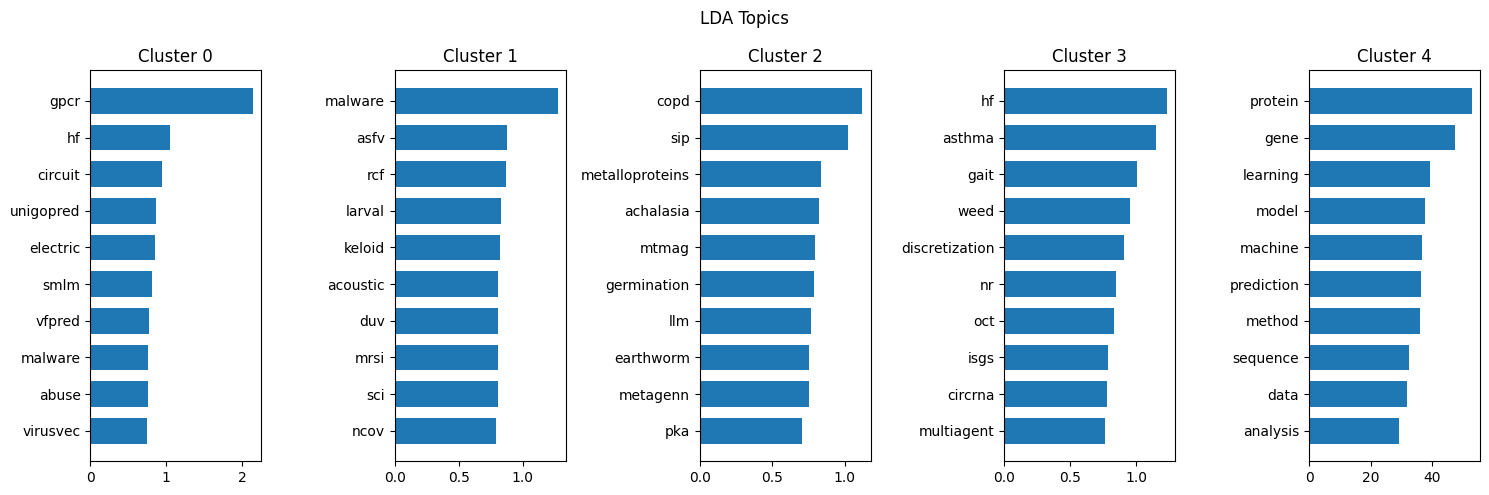

KMeans Misclassified Samples Analysis:

Cluster Misclassification Stats:
         Total  Misclassified    Purity
Cluster                                
0          163             10  0.938650
1          216             18  0.916667
2          194              5  0.974227
3          209             20  0.904306
4          218             35  0.839450


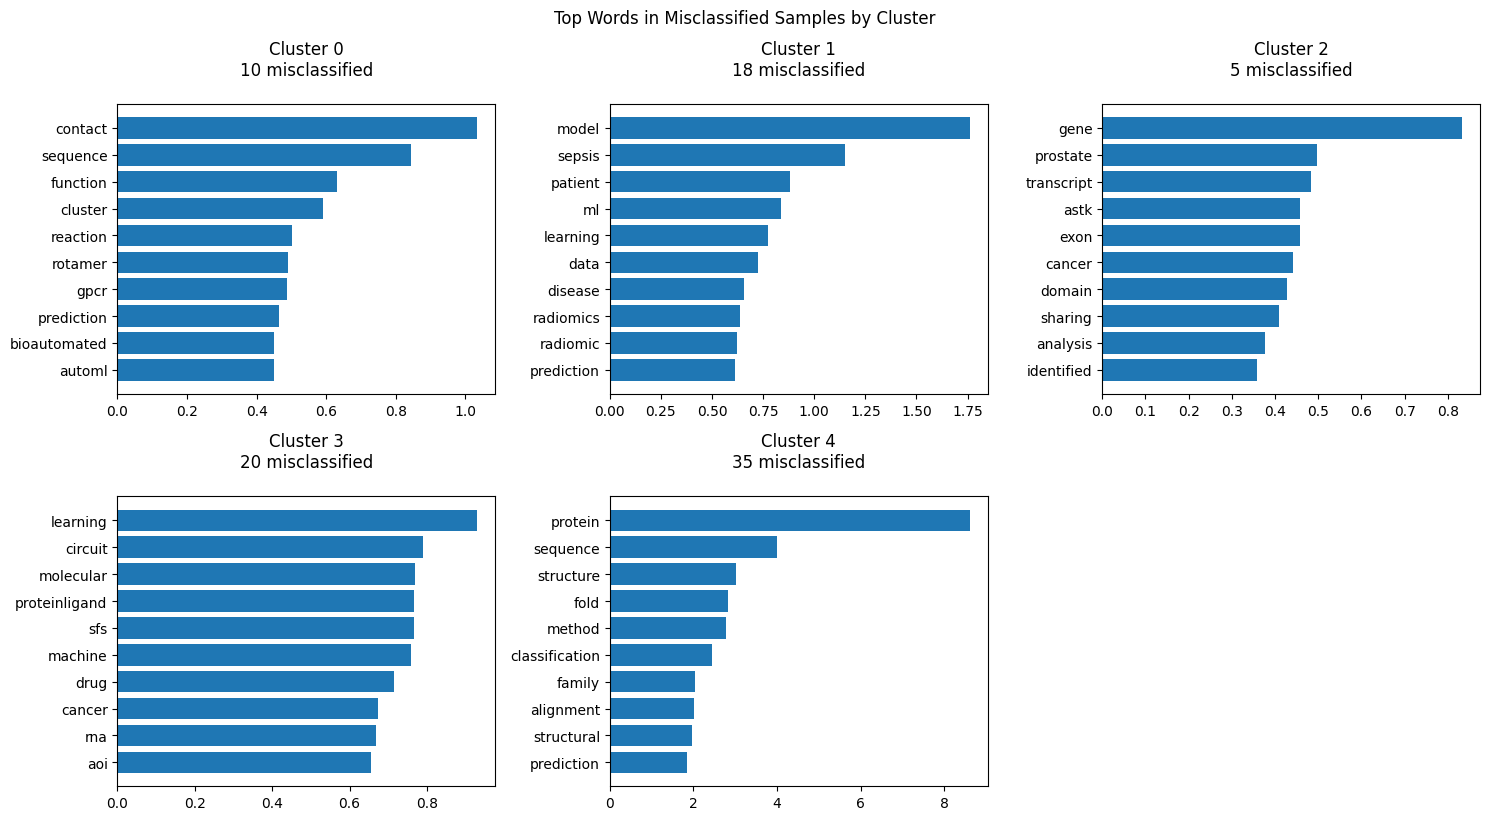

Cohen's Kappa KM (purged): 0.374


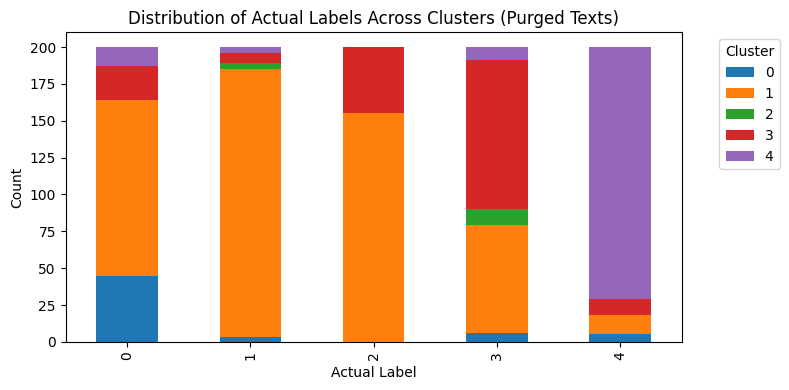

Purged Texts - KMeans vs LDA:
KMeans vs LDA - ARI: -0.003
KMeans vs LDA - NMI: 0.007


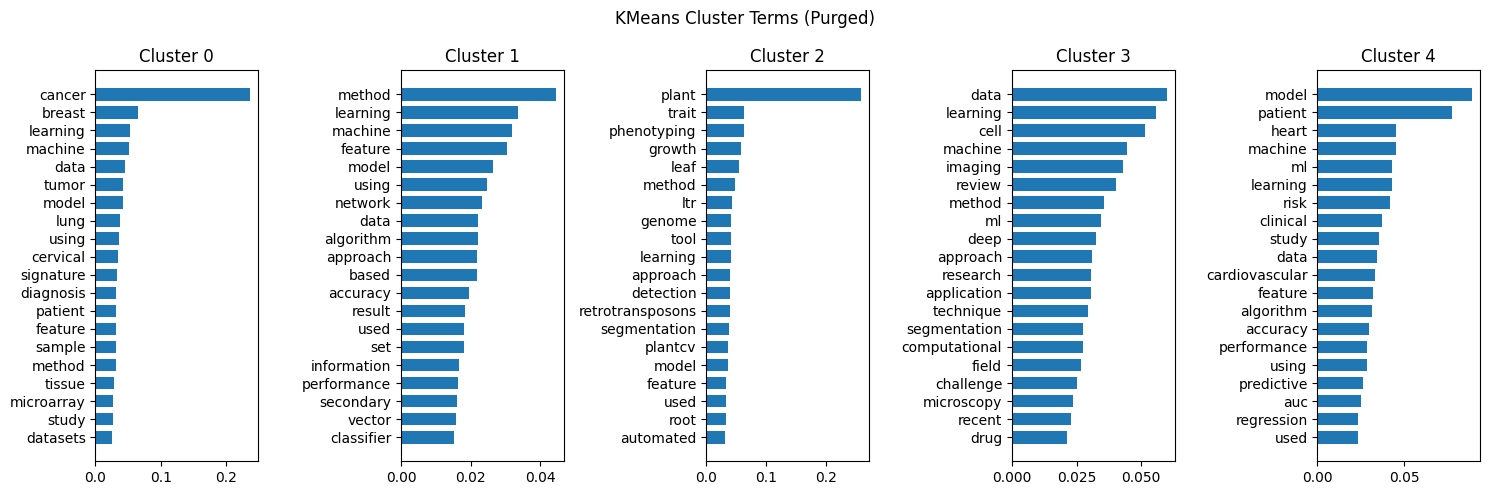

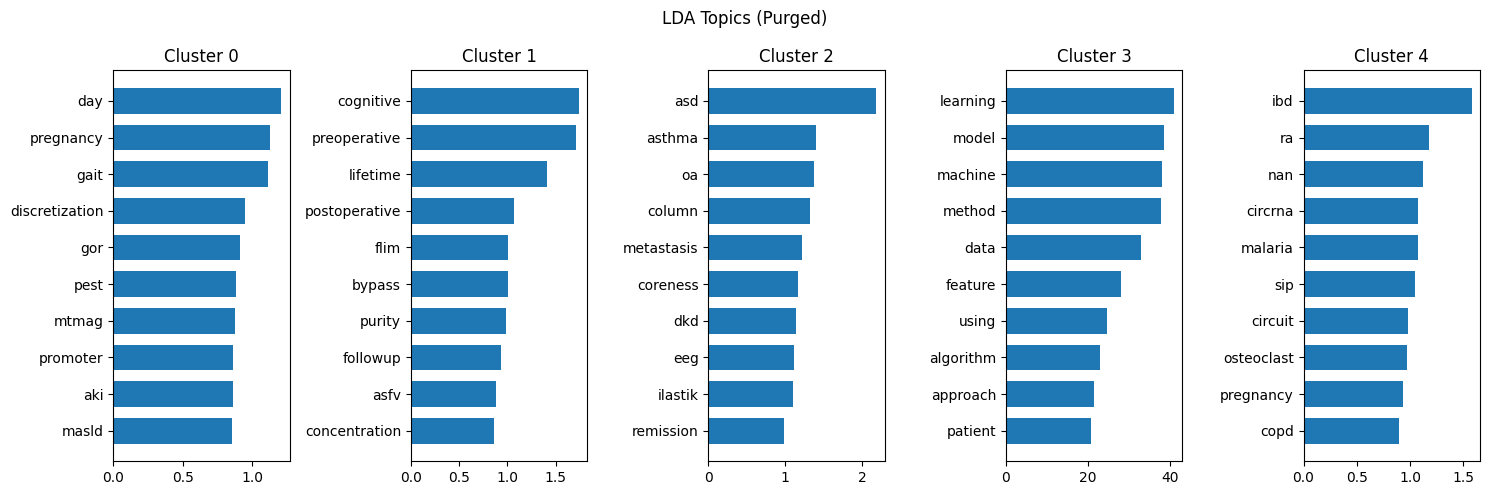

In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# --- Utility Functions ---

def align_cluster_labels(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_map = {pred: true for true, pred in zip(row_ind, col_ind)}
    aligned_labels = np.array([label_map[p] for p in pred_labels])
    return aligned_labels

def plot_top_words(weights, feature_names, n_top_words, title="Top Terms"):
    n_clusters = weights.shape[0]
    fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5))
    if n_clusters == 1:
        axes = [axes]
    for cluster_idx, cluster_weights in enumerate(weights):
        top_features_ind = cluster_weights.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        term_weights = cluster_weights[top_features_ind]
        ax = axes[cluster_idx]
        ax.barh(top_features, term_weights, height=0.7)
        ax.set_title(f"Cluster {cluster_idx}")
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_spectral_top_terms(labels, tfidf_matrix, feature_names, n_clusters):
    term_weights = np.zeros((n_clusters, tfidf_matrix.shape[1]))
    for cluster_id in range(n_clusters):
        cluster_mask = (labels == cluster_id)
        if np.sum(cluster_mask) > 0:
            term_weights[cluster_id] = tfidf_matrix[cluster_mask].mean(axis=0).A1
    return term_weights

def align_clusters_to_classes(true_labels, cluster_labels):
    conf_mat = confusion_matrix(true_labels, cluster_labels)
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    mapping = {cluster: class_ for cluster, class_ in zip(col_ind, row_ind)}
    return np.array([mapping[x] for x in cluster_labels])

def plot_misclassified_top_words_by_cluster(true_labels, cluster_labels, tfidf_matrix, terms, n_clusters, top_n=10):
    aligned_labels = align_clusters_to_classes(true_labels, cluster_labels)
    df = pd.DataFrame({
        'True': true_labels,
        'Cluster': cluster_labels,
        'Aligned': aligned_labels,
        'Misclassified': true_labels != aligned_labels
    })
    cluster_stats = df.groupby('Cluster').agg(
        Total=('True', 'count'),
        Misclassified=('Misclassified', 'sum'),
        Purity=('Misclassified', lambda x: 1 - x.mean())
    )
    print("\nCluster Misclassification Stats:")
    print(cluster_stats)
    plt.figure(figsize=(15, 8))
    for cluster in range(n_clusters):
        mis_indices = df[(df['Cluster'] == cluster) & df['Misclassified']].index
        plt.subplot(2, 3, cluster + 1)
        if len(mis_indices) > 0:
            cluster_tfidf = tfidf_matrix[mis_indices].sum(axis=0).A1
            top_indices = np.argsort(cluster_tfidf)[-top_n:][::-1]
            top_words = [terms[i] for i in top_indices]
            top_weights = [cluster_tfidf[i] for i in top_indices]
            plt.barh(range(top_n), top_weights, tick_label=top_words)
            plt.gca().invert_yaxis()
            plt.title(f'Cluster {cluster}\n{len(mis_indices)} misclassified\n')
        else:
            plt.text(0.5, 0.5, f'No misclassified\nsamples', ha='center', va='center')
            plt.title(f'Cluster {cluster} (100% purity)')
            plt.axis('off')
    plt.tight_layout()
    plt.suptitle('Top Words in Misclassified Samples by Cluster', y=1.02)
    plt.show()

def clean_text(text, words_to_clean):
    words = text.split()
    words = [word for word in words if word.lower() not in words_to_clean]
    return ' '.join(words)


# --- Load Your Data ---

# Path to your Excel file
excel_path = '/content/drive/My Drive/Colab/AS4/STEP1-data_prepare/final_labeled_dataset.xlsx'

doc_raw = pd.read_excel(excel_path)

# Map string labels to numeric labels
label_names = doc_raw['Label'].unique()
label_to_num = {label: idx for idx, label in enumerate(label_names)}
doc_raw['label_num'] = doc_raw['Label'].map(label_to_num)

texts = doc_raw['Text'].astype(str).tolist()
numeric_labels = doc_raw['label_num'].values

# --- Load Precomputed Feature Sets ---

DPPpath = '/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/'

def load_feature_set(path):
    df_tfidf = pd.read_pickle(path + 'features_tfidf.pkl')
    df_bow = pd.read_pickle(path + 'features_bow.pkl')
    df_lda = pd.read_pickle(path + 'features_lda.pkl')
    df_2gr = pd.read_pickle(path + 'features_ngram2.pkl')
    df_wv = pd.read_pickle(path + 'features_word2vec.pkl')
    labels = df_tfidf['label']
    numeric_labels_fs = df_tfidf['label_num'].values
    from sklearn.preprocessing import label_binarize
    classes = np.unique(numeric_labels_fs)
    y_binarized = label_binarize(numeric_labels_fs, classes=classes)
    X_tfidf = df_tfidf.drop(['label', 'label_num'], axis=1).values
    X_bow = df_bow.drop(['label', 'label_num'], axis=1).values
    X_lda = df_lda.drop(['label', 'label_num'], axis=1).values
    X_wv = df_wv.drop(['label', 'label_num'], axis=1).values
    X_2gr = df_2gr.drop(['label', 'label_num'], axis=1).values
    feature_sets = {
        'TF-IDF': X_tfidf,
        'BoW': X_bow,
        'LDA': X_lda,
        '2Grams': X_2gr,
        'Word2Vec': X_wv
    }
    return labels, numeric_labels_fs, feature_sets

labels_fs, numeric_labels_fs, feat = load_feature_set(DPPpath)

# --- TF-IDF Vectorization on Raw Text ---

vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(texts)
terms = vectorizer.get_feature_names_out()

# PCA to reduce dimensionality of precomputed TF-IDF features for clustering
pca = PCA(n_components=100, random_state=42)
tfidfp = pca.fit_transform(feat['TF-IDF'])

# Number of clusters (adjust to your dataset's classes if needed)
n_clusters = len(label_names)

# --- KMeans Clustering ---

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(tfidfp)
k_aligned_labels = align_cluster_labels(numeric_labels, kmeans_labels)
kkappa = cohen_kappa_score(numeric_labels, k_aligned_labels)
print(f"Cohen's Kappa KM: {kkappa:.3f}")

# Plot cluster distribution
df_plot = pd.DataFrame({'Actual': numeric_labels, 'Cluster': k_aligned_labels})
counts = df_plot.groupby(['Actual', 'Cluster']).size().unstack()
counts.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Distribution of Actual Labels Across Clusters')
plt.ylabel('Count')
plt.xlabel('Actual Label')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# --- LDA Topic Modeling ---

lda = LatentDirichletAllocation(n_components=n_clusters, random_state=42)
lda_output = lda.fit_transform(tfidf)
lda_labels = np.argmax(lda_output, axis=1)

# Compare clustering with LDA
print("Comparison Metrics:")
print(f"KMeans vs LDA - ARI: {adjusted_rand_score(kmeans_labels, lda_labels):.3f}")
print(f"KMeans vs LDA - NMI: {normalized_mutual_info_score(kmeans_labels, lda_labels):.3f}")

# Plot top words per cluster (KMeans) and per topic (LDA)
kmw = get_spectral_top_terms(k_aligned_labels, tfidf, terms, n_clusters)
plot_top_words(kmw, terms, 20, "KMeans Cluster Terms")
plot_top_words(lda.components_, terms, 10, "LDA Topics")

# --- Misclassification Analysis ---

print("KMeans Misclassified Samples Analysis:")
plot_misclassified_top_words_by_cluster(numeric_labels, kmeans_labels, tfidf, terms, n_clusters)

# --- Text Purging: Remove topic-label words from text ---

topics_words = set(word.lower() for label in label_names for word in label.split())

purged_texts = [clean_text(text, topics_words) for text in texts]

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_purged = vectorizer.fit_transform(purged_texts)
terms_purged = vectorizer.get_feature_names_out()
tfidfp_purged = PCA(n_components=100, random_state=42).fit_transform(tfidf_purged)

# Re-run KMeans on purged text features
kmeans_purged = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels_purged = kmeans_purged.fit_predict(tfidfp_purged)
k_aligned_labels_purged = align_cluster_labels(numeric_labels, kmeans_labels_purged)
kkappa_purged = cohen_kappa_score(numeric_labels, k_aligned_labels_purged)
print(f"Cohen's Kappa KM (purged): {kkappa_purged:.3f}")

df_purged = pd.DataFrame({'Actual': numeric_labels, 'Cluster': k_aligned_labels_purged})
counts_purged = df_purged.groupby(['Actual', 'Cluster']).size().unstack()
counts_purged.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title('Distribution of Actual Labels Across Clusters (Purged Texts)')
plt.ylabel('Count')
plt.xlabel('Actual Label')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# LDA on purged texts
lda_purged = LatentDirichletAllocation(n_components=n_clusters, random_state=42)
lda_output_purged = lda_purged.fit_transform(tfidf_purged)
lda_labels_purged = np.argmax(lda_output_purged, axis=1)
print("Purged Texts - KMeans vs LDA:")
print(f"KMeans vs LDA - ARI: {adjusted_rand_score(kmeans_labels_purged, lda_labels_purged):.3f}")
print(f"KMeans vs LDA - NMI: {normalized_mutual_info_score(kmeans_labels_purged, lda_labels_purged):.3f}")

kmw_purged = get_spectral_top_terms(k_aligned_labels_purged, tfidf_purged, terms_purged, n_clusters)
plot_top_words(kmw_purged, terms_purged, 20, "KMeans Cluster Terms (Purged)")
plot_top_words(lda_purged.components_, terms_purged, 10, "LDA Topics (Purged)")
